In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
import numpy as np


In [ ]:
df = pd.read_csv('master_transfers_list.csv')

In [ ]:
df.head()

In [ ]:
#group positions based on attack, mid, def, goalkeeper
positions = [df['position'].isin(['Centre-Forward',
                                  'Left Winger',
                                  'Right Winger',
                                  'Striker',
                                  'Second Striker',
                                  'Forward']),
            (df['position'].isin(['Central Midfield',
                                'Attacking Midfield',
                                'Defensive Midfield',
                                'Right Midfield',
                                'Midfielder'])),
             (df['position'] == 'Goalkeeper')]
             
generic_position = ['Attacker', 'Midfielder', 'Goalkeeper']

df['generic_position'] = np.select(positions, generic_position, default = 'Defender')

#one example of player not showing up correctly: Coutinho (listed as forward instead of midfield)
df.loc[df['player_name'].str.contains('Coutinho'),'generic_position'] = 'Midfielder'

In [ ]:
df[df['league_name']=='Primera Division']

In [ ]:
#drop players where fee_cleaned==NA
df.dropna(subset = ['fee_cleaned'], inplace=True)
df = df[df['fee_cleaned'] > 0.1]
#keep only players with transfers "in" to club - not leaving (duplicates otherwise)
df = df[df['transfer_movement'] == 'in']
#make new variable: player_name + club_name
df['player_name_club'] = df.apply(lambda x: str(x['player_name'] + ' (' + x['club_name'] + ')'), axis=1)

#drop duplicates of player_name_club: on off chance player made two changes 
df.drop_duplicates(subset = ['player_name_club'], keep = 'last', inplace=True )

In [7]:
df.head(10)
df[df['player_name_club'].str.contains('Couti')]
#df[df['club_name'].str.contains('Madrid')].sort_values('fee_cleaned', ascending=False)

Unnamed: 0          club_name        player_name   age  \
95756          464       Liverpool FC  Philippe Coutinho  20.0   
113109           4  FC Internazionale  Philippe Coutinho  16.0   
155964          19       FC Barcelona  Philippe Coutinho  25.0   
169584           3      Bayern Munich  Philippe Coutinho  27.0   

                  position club_involved_name              fee  \
95756          Left Winger              Inter          £11.70m   
113109         Left Winger          Vasco U17           £3.42m   
155964         Left Winger          Liverpool         £130.50m   
169584  Attacking Midfield       FC Barcelona  Loan fee:£7.65m   

       transfer_movement  fee_cleaned       league_name  year     season  \
95756                 in        11.70    Premier League  2012  2012/2013   
113109                in         3.42           Serie A  2008  2008/2009   
155964                in       130.50  Primera Division  2017  2017/2018   
169584                in         7.65      1 Bundesliga  2019  2019/2020   

       generic_position                       player_name_club  
95756        Midfielder       Philippe Coutinho (Liverpool FC)  
113109       Midfielder  Philippe Coutinho (FC Internazionale)  
155964       Midfielder       Philippe Coutinho (FC Barcelona)  
169584       Midfielder      Philippe Coutinho (Bayern Munich)

In [8]:
#average increase per year
year_over_year_increase = df[df['league_name'].isin(['Serie A', 'Premier League', 'Ligue 1',
       '1 Bundesliga', 'Primera Division'])].groupby('year').mean()
year_over_year_increase.fee_cleaned


year
1992    1.963356
1993    1.339713
1994    1.275019
1995    1.759910
1996    2.191371
1997    2.791435
1998    3.289608
1999    4.087004
2000    4.898266
2001    5.457108
2002    4.565542
2003    3.793952
2004    3.526712
2005    3.008036
2006    3.148000
2007    3.633924
2008    3.681328
2009    4.137654
2010    3.421011
2011    3.218426
2012    3.368881
2013    4.513846
2014    4.861582
2015    5.499193
2016    6.170760
2017    8.124610
2018    7.298331
2019    9.166720
Name: fee_cleaned, dtype: float64

In [9]:
#Get top 10 transfers for each year + position; sort by fee_cleaned, group by, and take top 10
top_transfers = df.sort_values(by=['fee_cleaned'],ascending=False).groupby(['year','generic_position']).head(10)

#keep necessary columns only
top_transfers = top_transfers[['player_name_club', 'club_name','fee_cleaned','year','generic_position']]

#Sort by year
top_transfers = top_transfers.sort_values(by=['year'],ascending=True)



In [10]:
#complete rows to keep player row after year of signing (i.e. player_x signed in 2018, keep player_x in 2019 data as well)
#credit to: https://stackoverflow.com/questions/40093971/pandas-dataframe-insert-fill-missing-rows-from-previous-dates 
levels = ['year','player_name_club']
full_idx = pd.MultiIndex.from_product([top_transfers[col].unique() for col in levels], names=levels)
top_transfers_complete = top_transfers.set_index(levels).reindex(full_idx)


top_transfers_complete = top_transfers_complete.groupby(level=['player_name_club']).ffill().reset_index()

top_transfers_complete.fillna(0, inplace=True)

In [11]:
top_transfers_complete[top_transfers_complete['player_name_club'].str.contains('Kant')].tail(10)

year           player_name_club   club_name  fee_cleaned  \
21026  2010  N'Golo Kanté (Chelsea FC)           0         0.00   
22139  2011  N'Golo Kanté (Chelsea FC)           0         0.00   
23252  2012  N'Golo Kanté (Chelsea FC)           0         0.00   
24365  2013  N'Golo Kanté (Chelsea FC)           0         0.00   
25478  2014  N'Golo Kanté (Chelsea FC)           0         0.00   
26591  2015  N'Golo Kanté (Chelsea FC)           0         0.00   
27704  2016  N'Golo Kanté (Chelsea FC)  Chelsea FC        32.22   
28817  2017  N'Golo Kanté (Chelsea FC)  Chelsea FC        32.22   
29930  2018  N'Golo Kanté (Chelsea FC)  Chelsea FC        32.22   
31043  2019  N'Golo Kanté (Chelsea FC)  Chelsea FC        32.22   

      generic_position  
21026                0  
22139                0  
23252                0  
24365                0  
25478                0  
26591                0  
27704       Midfielder  
28817       Midfielder  
29930       Midfielder  
31043       Midfielder

In [12]:
current_year = 2019
dff = (top_transfers_complete[top_transfers_complete['year'].eq(current_year)]
       .sort_values(by='fee_cleaned', ascending=False)
       .head(10))
dff

year                     player_name_club            club_name  \
31063  2019         Neymar (Paris Saint-Germain)  Paris Saint-Germain   
31046  2019     Philippe Coutinho (FC Barcelona)         FC Barcelona   
31108  2019  Kylian Mbappé (Paris Saint-Germain)  Paris Saint-Germain   
31136  2019         João Félix (Atlético Madrid)      Atlético Madrid   
31049  2019       Ousmane Dembélé (FC Barcelona)         FC Barcelona   
31131  2019     Antoine Griezmann (FC Barcelona)         FC Barcelona   
31117  2019      Cristiano Ronaldo (Juventus FC)          Juventus FC   
31014  2019       Paul Pogba (Manchester United)    Manchester United   
30916  2019            Gareth Bale (Real Madrid)          Real Madrid   
31133  2019            Eden Hazard (Real Madrid)          Real Madrid   

       fee_cleaned generic_position  
31063        199.8         Attacker  
31046        130.5       Midfielder  
31108        121.5         Attacker  
31136        113.4         Attacker  
31049        112.5         Attacker  
31131        108.0         Attacker  
31117        105.3         Attacker  
31014         94.5       Midfielder  
30916         90.9         Attacker  
31133         90.0         Attacker

In [13]:
def draw_indiv_barchart(ax,df, position,year):
    df = df[df.generic_position == position]
    dff = df[df['year'].eq(year)].sort_values(by='fee_cleaned', 
                                              ascending=True).tail(5)
    ax.clear()
    ax.set_xlim([0, 250])
    ax.set_xticks(np.arange(0, 250, 50))
    ax.barh(dff['player_name_club'], dff['fee_cleaned'])
    dx = dff['fee_cleaned'].max() / 200
    
    for i, (value, name) in enumerate(zip(dff['fee_cleaned'], dff['player_name_club'])):
        ax.text(value + dx, i + 0.1, '    ' + name, color='#3b4463',size=16, weight=600, 
                ha='left', va='bottom', fontdict = {'fontname': 'Georgia'})
        ax.text(value + dx, i - 0.1, '   £'+str(value)+'mil', size = 14, weight =200,
                ha = 'left', va = 'center', fontdict = {'fontname': 'Georgia'})
    ax.text(0, 1.09, '  £ (Millions)', transform=ax.transAxes, size=16, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=14)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.xaxis.set_ticks_position('top')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)    
    plt.subplots_adjust(left = 0.075, right = 0.75, top = 0.825, bottom = 0.05, wspace = 0.2, hspace = 0.2)
    plt.locator_params(axis = 'x', nbins = 12)
    plt.box(False)



In [14]:

def draw_subplots(year):
    
    for ax, position in ax_dict.items():
        draw_indiv_barchart(ax,top_transfers_complete,position,year)
        if ax == ax1:
            ax.set_title(year, size=42, weight=600, ha='center',fontdict = {'fontname': 'Georgia'}, y = 1.1)
        ax.set_ylabel(position, size = 22,fontdict = {'fontname': 'Georgia'})
        

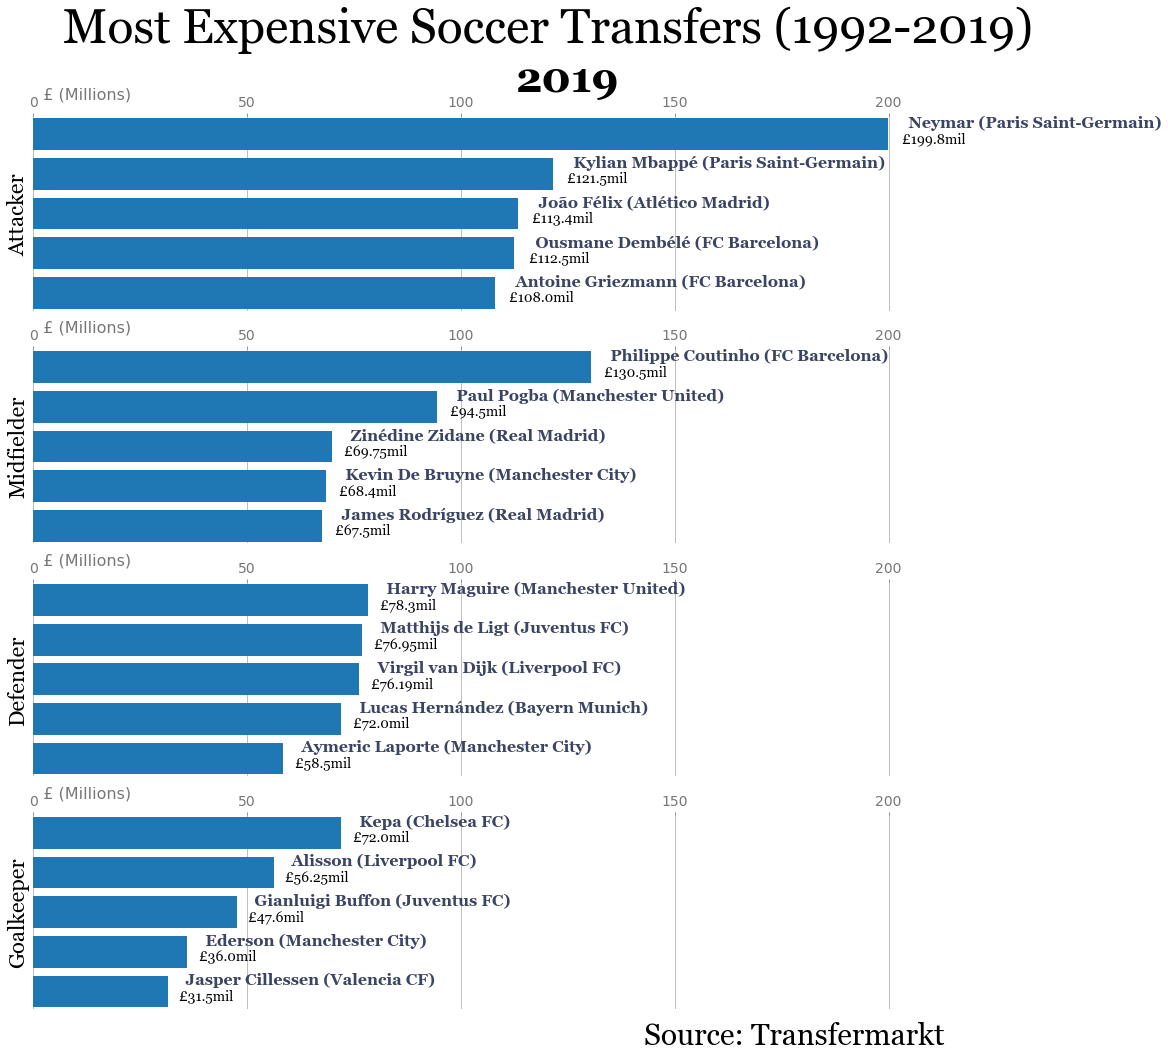

In [31]:
current_year=2019

fig, (ax1, ax2,ax3,ax4) = plt.subplots(4,figsize=(22, 16))
fig.suptitle('Most Expensive Soccer Transfers (1992-2019)', 
             ha='center', va='center', y= 0.9, x = 0.4,
           fontsize=48, fontdict = {'fontname': 'Georgia'})
ax1.set_ylabel('Attacker')
fig.text(0.65, 0.02, 'Source: Transfermarkt', ha='right',fontsize=30,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'),fontdict = {'fontname': 'Georgia'})

ax_dict = {ax1: "Attacker",
          ax2: "Midfielder",
          ax3 : "Defender",
          ax4: "Goalkeeper"}
draw_subplots(year = current_year)

fig.savefig('plot.png')







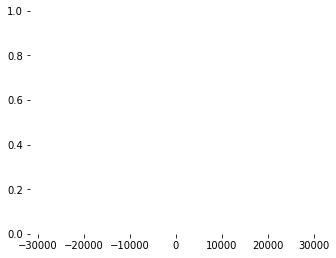

In [32]:
animator = animation.FuncAnimation(fig, draw_subplots, frames=range(1992, 2020), interval = 1200)
HTML(animator.to_jshtml()) 



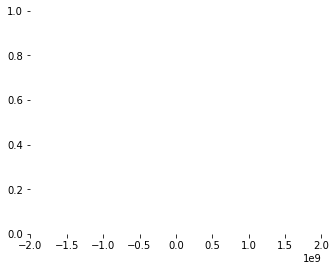

In [34]:
animator.save('animation_top.gif', writer='imagemagick', fps = 2, bitrate = 1800)
animator.save('animation_bottom.gif', writer='imagemagick', fps = 0.7, bitrate = 2200)

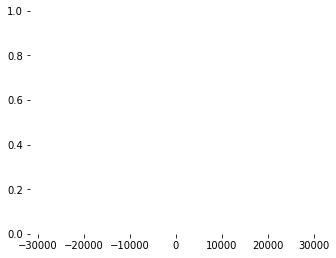